# Predict if a football player will increase in valuation using Football Manager data

The goal of this project is to be able to predict football players who will have an increase in their value in the future, using Football Manager (FM) data.

FM is a cheap and easily accessible database of football players. By being able to predict which players would have an increase in their value using only this database would help football clubs decide better in which players to invest.

There is not a lot of literature available for studies using FM data in this situation. However the following one was found:
- [Predicting the Potential Ability of Football Players in the Football Manager Game](williamvanwijk.nl/wp-content/uploads/2022/07/Thesis_FM_Predict_potential_ability.pdf)
    - This study concludes that it is possible to predict an increase in real-life value using publicly available FM data. However, the focus of this study was to predict not the value but an increase in PA such as this value would be above a certain threshold (130) which is given to high-potential players.

## Overview of the project and data

I used the following datasets for this project:

- FM20 dataset: https://www.kaggle.com/datasets/ktyptorio/football-manager-2020
    - This dataset will be used in order to evaluate whether the information we have in a given iteration of FM - not taking into account any history - is a good predictor of an increase in valuation.
- Transfermarkt: https://www.kaggle.com/datasets/davidcariboo/player-scores 
    - This dataset provides the player valuations from Transfermarkt, a well-known aggregator for player valuations.

## Exploratory Data Analysis

Here a very basic and superficial EDA was made.

First I imported the libraries and the datasets (FM20, Transfermarkt Players and Transfermarkt valuations over time).

In [2]:
from src.libs import *

fm20_dataset = pd.read_csv("datasets/datafm20.csv")
transfermarkt_players_dataset = pd.read_csv("datasets/players.csv")
transfermarkt_valuations_dataset = pd.read_csv("datasets/player_valuations.csv")

Here I wanted to understand at what age do players have their peak, and when they devalue. As expected, this graph follows a normal distribution, with the peak being around 27/28 yo. There is a linear increase from 15-27, followed by a sharper decrease in value from 28-35 yo.

Here I removed the Goalkeepers as they will not be the focus of our investigation (as they have very specific attributes)

<AxesSubplot:xlabel='Age'>

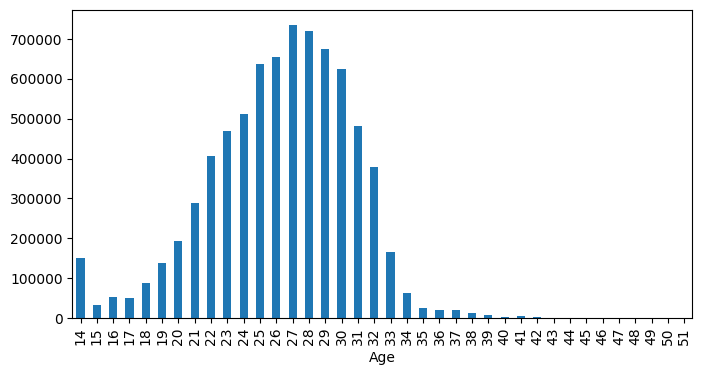

In [3]:
fm20_df_no_gk = fm20_dataset[:].query('`Best Pos` != "GK"')

new_fm20_df = fm20_df_no_gk[:]
new_fm20_df['POT'] = new_fm20_df['PA'] - new_fm20_df['CA']
new_fm20_df.groupby('Age')['Value'].mean().plot(kind='bar')

Here I want to add some attribute combinations as possible features, and also see if they correlate well with the player value.

In [4]:
new_fm20_df = fm20_df_no_gk[:][['Value', 'Age'] + PLAYER_ATTR]

apply_mean_attribute_list(new_fm20_df, 'PHY', ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat'])
apply_mean_attribute_list(new_fm20_df, 'MEN', ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg'])
apply_mean_attribute_list(new_fm20_df, 'M+P', ['MEN', 'PHY'])
apply_mean_attribute_list(new_fm20_df, 'ATTR', PLAYER_ATTR)

As we can see here, the attribute combinations correlate better with value than any individual attribute.

In [5]:
new_fm20_df.corr()['Value'].sort_values(ascending=False).head(5)

Value    1.000000
M+P      0.292927
ATTR     0.277248
MEN      0.268462
PHY      0.266174
Name: Value, dtype: float64

As we can see here, age has a small positive correlation with the value, which was expected given that the peak of a player's valuation is more or less in the middle of his career.

In [6]:
new_fm20_df.corr()['Value'].sort_values(ascending=True).head(5)

Age    0.038035
Mar    0.067548
Ldr    0.067727
Agg    0.074689
Nat    0.079667
Name: Value, dtype: float64

Here I want to analyse the FIFA World Rankings dataframe. I will use this data to transform each country of birth into a value (and see if there is any relevance to that data)

In [7]:
fifa_wr = pd.read_csv("datasets/fifa_ranking-2021-05-27.csv")
fifa_wr.columns
fifa_wr['rank_date'].drop_duplicates()[fifa_wr['rank_date'].drop_duplicates().str.startswith('2020')].sort_values()

60744    2020-02-20
60954    2020-04-09
61164    2020-06-11
61374    2020-07-16
61584    2020-09-17
61794    2020-10-22
62004    2020-11-26
62214    2020-12-10
Name: rank_date, dtype: object

My EDA was not finished here, however most of the code was unfortunately either removed or not documented.

Some additional work that should have been done within the EDA:
- Check null values
- Check outliers (3 std dev.) z-score > 3 or z-score < -3 ignore
- Prove within notebook that it is clean
- pd.describe()
- Use seaborn for heatmap of correlations

## Data preparation

I wanted to prepare the main dataset for usage in creating the model. This dataset will contain the matching players from FM20 and Transfermarkt, including their valuations and change in valuation from 2020 to 2022.

For that, I prepared both datasets to be merged. 

I selected only players with less than 27 y.o. This decision was made so we can focus only on players with a high probability of increasing in value (we assume as players get older than this, the probability of a value increase is much smaller).

In [8]:
transfermarkt_base_players_df = transfermarkt_players_dataset[:]
transfermarkt_base_players_df.query("last_season >= 2021 & date_of_birth >= '1992-01-01' & position != 'Goalkeeper'", inplace=True)
transfermarkt_base_players_df.dropna(subset='market_value_in_gbp')

fm20_base_players_df = fm20_dataset.query("Age <= 27 & `Best Pos` != 'GK'")

To merge both dataframes we need to figure out what will be the criteria for players to "match". We decided to use:
- Player name and nation should always match
- If the name and nation matches for more than one player, the player value will be the tiebreaker (so the highest valued match in one dataset will match in the other dataset) 

So first I ordered both datasets by value. Some players in the transfermarkt dataset didn't have value so I dropped those.

In [9]:
transfermarkt_base_players_df.dropna(subset='market_value_in_gbp')
transfermarkt_base_players_df.sort_values(by='market_value_in_gbp', ascending=False, inplace=True)

fm20_base_players_df.sort_values(by='Value', ascending=False, inplace=True)

First I made a script which matched the name in FM with the name which appears as unique in Transfermarkt. This will be used to match players in FM and Transfermarkt.

In [10]:
fm20_base_players_df['Transfermarkt_Name'] = fm20_base_players_df['Name'].apply(name_char_replacer).apply(name_to_id)

Then, I mapped the country of citizenship in Transfermarkt to the country codes in FM20. This was made by first capturing the 5 most valuable players of each nation, find what is the matching *country_of_citizenship* in Transfermarkt, and then match that to the FM20 *Nation* of those players.

In [11]:
fm20_name_nation_mapping = fm20_base_players_df.groupby('Nation').head(5)[['Transfermarkt_Name', 'Nation']]

transfermarkt_name_nation_mapping = transfermarkt_players_dataset[['name', 'country_of_citizenship']]

player_nationalities_mapping = fm20_name_nation_mapping.merge(transfermarkt_name_nation_mapping, left_on='Transfermarkt_Name', right_on='name')
player_nationalities_mapping.drop_duplicates(subset='Nation', inplace=True)

fm20_base_players_df = fm20_base_players_df.merge(player_nationalities_mapping[['Nation', 'country_of_citizenship']], on='Nation')

Here I make my first attempt in merging both datasets, using only the name and country of citizenship. I create our **merged dataframe** called *transfermarkt_fm20_merged_df*.

In [12]:
transfermarkt_fm20_merged_df = fm20_base_players_df.merge(transfermarkt_base_players_df, left_on=['Transfermarkt_Name', 'country_of_citizenship'], right_on=['name', 'country_of_citizenship'])

transfermarkt_fm20_merged_df.drop_duplicates(subset=['Transfermarkt_Name', 'country_of_citizenship'], inplace=True)

Here I try to get more results than those I get previously.
- I get all the merged players who are missing from *base_players_df*.
- I sort them by market_value and then figure out their age in 2020 based on the *date_of_birth* (the data I have in Transfermarkt)
    - I can't know an accurate DOB as I only have the age of the player in the FM20 dataframe, and I don't know exactly when the age was "measured"
- Finally, I apply a function which is sort of a fuzzy search taking into account that the name, country, age and market value are within a certain range
    - The name is fuzzy searched with difflib.get_close_matches
    - The value in FM should be greater than or equal to 1/5 of the Transfermarkt value.
    - The age on FM should be equal to the Transfermarkt age or equal to the Transfermarkt age - 1 (due to not knowing exactly if a player already had their birthday or not in FM, the approximate_age_2020 function rounded upwards)

TODO: I would love some tips on performance on this fuzzy search

In [13]:
missing = transfermarkt_base_players_df.merge(transfermarkt_fm20_merged_df, indicator='i', how='outer').query('i == "left_only"')[transfermarkt_base_players_df.columns]

missing.sort_values(by='market_value_in_gbp', ascending=False, inplace=True)
missing['Age_2020'] = missing['date_of_birth'].apply(approximate_age_2020)
missing_fm = fm20_base_players_df[:]

def find_match(player):
    global missing_fm
    country = player['country_of_citizenship']
    age = player['Age_2020']
    value = player['market_value_in_gbp'] / 5
    age_minus = age - 1
    potential_players = missing_fm.query('country_of_citizenship == @country and (Age == @age_minus or Age == @age) and Value >= @value')
    player_name = next(iter(difflib.get_close_matches(player['name'], potential_players['Name'], cutoff=0.5)), None)
    if player_name:
        player_fm = potential_players.query('Name == @player_name').sort_values(by='Value', ascending=False).head(1)
        missing_fm = missing_fm.drop(player_fm.index)
        return player_fm.index
    return None


matches = missing.apply(find_match, axis=1)

print(f"Newly matched players: {len(matches.index)}")

Newly matched players: 1268


Here I append the newly matched values from the missing dataframe values to our **merged dataframe**.

In [14]:
tfmk_missing = missing.merge(matches.to_frame('fm_player_index'), left_index=True, right_index=True).dropna()
tfmk_missing['fm_player_index'] = tfmk_missing['fm_player_index'].apply(lambda x: x.tolist()[0])
tfmk_missing = tfmk_missing.merge(fm20_base_players_df, left_on='fm_player_index', right_index=True)
transfermarkt_fm20_merged_df = transfermarkt_fm20_merged_df.append(tfmk_missing)

Here I insert the target values (valuation now vs valuations 2020) into the **merged dataframe**. This is made using the *transfermarkt_valuations_dataset* and finding the players' values in 2020, and comparing them with their value now using *market_value_in_gbp*. This creates the **final dataframe** called *players_with_values*.

In [15]:

transfermarkt_fm20_merged_df['value_2022'] = transfermarkt_fm20_merged_df['market_value_in_gbp']

player_values_2020 = transfermarkt_valuations_dataset.query("date >= '2019-07-01' & date <= '2020-12-31'").sort_values(by='date', ascending=True).drop_duplicates(subset='player_id')

player_values_2020['value_2020'] = player_values_2020['market_value']

players_with_values = transfermarkt_fm20_merged_df.merge(player_values_2020, on='player_id')

players_with_values['value_diff'] = players_with_values['value_2022'] - players_with_values['value_2020']

players_with_values.to_csv('assets/base_players_dataset.csv', index=False)

Having my **final dataframe**, I proceeded to evaluate if they were evenly distributed for a classifier, and if I needed to do any change to correct any imbalance.

<AxesSubplot:>

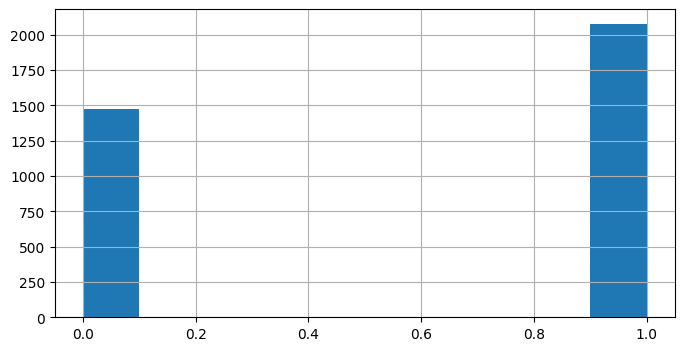

In [16]:
value_bins = [-np.inf, 0, np.inf]

base_players_dataset = players_with_values[:]

base_players_dataset['value_cat'] = pd.cut(players_with_values["value_diff"], bins=value_bins, labels=range(len(value_bins)-1))

base_players_dataset['value_cat'].hist()

Knowing that there is a very small imbalance, which is not meaningful, I proceed with creating the test and train sets, taking into account the player categories (to have representative test and train sets as well)

In [17]:
from sklearn.model_selection import train_test_split

players_for_analysis = base_players_dataset[:]

players_for_analysis.dropna(subset=['value_cat'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(players_for_analysis, players_for_analysis['value_cat'], test_size=0.2, random_state=42, stratify=players_for_analysis['value_cat'])

players_v1 = x_train.drop('value_cat', axis=1)

players_labels_v1 = x_train['value_cat'].copy()

Here I handle text and categorical attributes. For this, I create a series of Custom Transformers which turn some attributes into relevant data:

NationToRank transforms each nation into a numerical value between 0 and 1 according to their rank (1 the highest), according to the FIFA rankings in 2020.

In [18]:

from sklearn.base import BaseEstimator, TransformerMixin

class NationToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        nation_encoder = base_players_dataset.groupby('Nation').sum().rank(ascending=True, method='first')
        max_rank = nation_encoder['value_diff'].max()
        temp = nation_encoder.copy()
        temp.sort_values('value_diff', ascending=False, inplace=True)
        temp['Nation'] = temp.index
        temp.reset_index(drop=True, inplace=True)
        temp['Nation_rank'] = 1 - (temp.index / temp.shape[0])
        X['Nation_rank'] = X['Nation'].map(temp.set_index('Nation')['Nation_rank'])
        X.drop('Nation', axis=1, inplace=True)
        
        # fifa_wr = pd.read_csv("datasets/fifa_ranking-2021-05-27.csv")
        # nation_encoder = fifa_wr.query('rank_date == "2020-10-22"')[['rank', 'country_abrv']]
        # max_rank = nation_encoder['rank'].max() + 1
        # X['Nation_rank'] = 1 - (X['Nation'].map(nation_encoder.set_index('country_abrv')['rank']).fillna(max_rank) / max_rank)
        # X.drop('Nation', axis=1, inplace=True)
        return X

AttributeMerger merges groups of attributes together and returns a value between 0 and 1 for each group.

In [19]:

from sklearn.preprocessing import StandardScaler

class AttributeMerger(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        physical_attr = ['Acc', 'Pac', 'Sta', 'Str', 'Agi', 'Bal', 'Jum', 'Nat']
        mental_attr = ['Wor', 'Vis', 'Tea', 'Pos', 'OtB', 'Ldr', 'Fla', 'Det', 'Dec', 'Cnt', 'Cmp', 'Bra', 'Ant', 'Agg']
        apply_mean_attribute_list(X, 'M+P', physical_attr + mental_attr)
        apply_mean_attribute_list(X, 'MEN', mental_attr)
        apply_mean_attribute_list(X, 'PHY', physical_attr)
        apply_mean_attribute_list(X, 'ATTR', PLAYER_ATTR)
        X.drop(PLAYER_ATTR, axis=1, inplace=True)
        return X


BasedToRank transforms the championship where a player is playing into a value between 0 and 1, that was calculated taking into account the value generated in transfers by each championship. E.g. in this ranking the Portuguese Premier League is the league which increases the value of their players the most, so it gets the value of 1.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class BasedToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        based_encoder = pd.read_csv('assets/based_rank.csv')
        X['Based_rank'] = X['Based'].map(based_encoder.set_index('Based')['Based_rank'])
        X['Based_rank'].fillna(0, inplace=True)
        X.drop('Based', axis=1, inplace=True)
        return X

FootToRank transforms the footedness of the player (as indicated by FM) to a value between 0 and 1. In FM the technical attributes are affected by the footedness, and double footed players have a bit less technical attributes (but higher on both feet).

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class FootToRank(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['Foot_rank'] = X['Preferred Foot'].map(FOOTEDNESS_MAPPING)
        X.drop('Preferred Foot', axis=1, inplace=True)
        return X

Here we apply all transformations. We apply an additional two transformations to the age and the preferred position of a player:
- StandardScaler to standardize the age
- OneHotEncoder to split the preferred positions in different columns

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

players = x_train.drop('Value', axis=1)

features_v1 = {
    'att': (PLAYER_ATTR, ['M+P', 'MEN', 'PHY', 'ATTR']),
    'num': (PLAYER_ATTR + ['Age'], None),
    'foo': (['Preferred Foot'], None),
    'pos': (['Best Pos'], None),
    'nat': (['Nation'], None),
    'bas': (['Based'], None)
}

feature_labels_v1 = list(np.concatenate([f[1] if f[1] is not None else f[0] for k, f in features_v1.items()]).flat)

full_pipeline_v1 = ColumnTransformer([
    ("att", AttributeMerger(), features_v1['att'][0]),
    ("num", StandardScaler(), features_v1['num'][0]),
    ("foo", FootToRank(), features_v1['foo'][0]),
    ("pos", OneHotEncoder(), features_v1['pos'][0]),
    ("nat", NationToRank(), features_v1['nat'][0]),
    ("bas", BasedToRank(), features_v1['bas'][0])
])

players_prepared_v1 = full_pipeline_v1.fit_transform(players)

## Model selection and training

Here I decided to use a classifier, as I want to only classify the players in two categories (profit or not), and I opt to use a random forest for its ease of use and versatility.

Below I try to find the best hyperparameters to maximize the increase in value difference using the method *predictor_performance*. What this does is:
- Apply the model
- Sum the *value_diff* where there was a positive prediction: this would be the value earned, and includes the value lost from bad predictions.
- Sum the total positive *value_diff*: this would be the best prediction possible.
- Divide the first by the second to get the score.

After finding the best hyperparameters, I use the best estimator as my model and I save it.

TODO: Use XGBoost or Adaboost to improve the tuning

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

tune_hyperparameters = True
cross_validation = 10

if not tune_hyperparameters:
    value_predictor_v1 = joblib.load('models/rf_value_predictor.pkl')
else:
    def predictor_performance(estimator, X, y):
        y_pred = estimator.predict(X)
        values = x_train[['value_diff']]
        values['y_true'] = y
        values.dropna(inplace=True)
        values['pred'] = y_pred

        value_earned = values.query('pred == 1')['value_diff'].sum()
        total_value = values.query('value_diff > 0')['value_diff'].sum()

        return value_earned / total_value

    rf_param_grid = {
        'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 20)],
        'max_depth': [int(x) for x in np.linspace(10, 100, num = 5)] + [None],
        'bootstrap': [True, False],
    }

    value_predictor_v1 = RandomForestClassifier()
    value_predictor_v1_grid_search = RandomizedSearchCV(value_predictor_v1, rf_param_grid, cv=cross_validation, scoring=predictor_performance, return_train_score=True, n_iter=10, error_score="raise")

    value_predictor_v1_grid_search.fit(players_prepared_v1, players_labels_v1)

    value_predictor_v1 = value_predictor_v1_grid_search.best_estimator_

    joblib.dump(value_predictor_v1, 'models/rf_value_predictor.pkl')

value_predictor_v1

RandomForestClassifier(bootstrap=False, max_depth=10, n_estimators=352)

In here I want to find the best threshold which maximizes the value earned. To do that I test 100 tresholds for the *predict_proba* function of the predictor and figure out which one is the best.

In [24]:
value_predictions_proba_v1 = value_predictor_v1.predict_proba(players_prepared_v1)

total_value_without_model = x_train['value_diff'].sum()
max_value_without_model = x_train.query('value_diff > 0')['value_diff'].sum()

max_performance = max_value_without_model

train_players = x_train[:]
train_players['prob_1'] = value_predictions_proba_v1[:, 1]

model_performance_max = 0
ideal_threshold = 0
total_value_with_model_max = 0

for i in range(100):
    threshold = i / 100
    train_players['pred'] = value_predictions_proba_v1[:, 1] > threshold
    total_value_with_model = train_players.query('pred == 1')['value_diff'].sum()
    model_performance = total_value_with_model
    if model_performance > model_performance_max:
        model_performance_max = model_performance
        ideal_threshold = threshold
        total_value_with_model_max = total_value_with_model

print("Perf:", model_performance_max)
print("Max Perf:", max_performance)
print("Thres:", ideal_threshold)

Perf: 6584072993.0
Max Perf: 6642244993.0
Thres: 0.47


The confusion matrix shows a really good performance overall with the training set.

<AxesSubplot:>

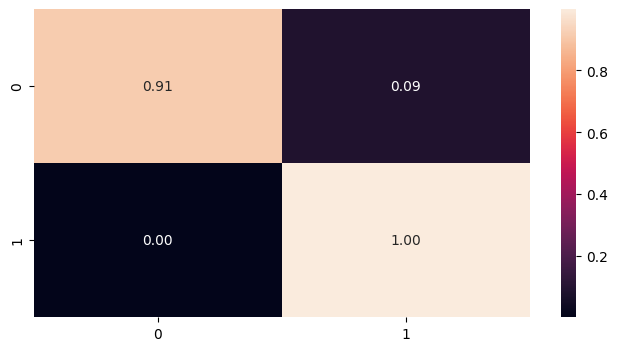

In [25]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(players_labels_v1, value_predictions_proba_v1[:, 1] > ideal_threshold)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

## Testing and Error Analysis

Now the real deal. We prepare the test values and run the model with them.

In [26]:
test_players_prepared = full_pipeline_v1.fit_transform(x_test)
test_players_labels = y_test
test_value_predictions_proba_v1 = value_predictor_v1.predict_proba(test_players_prepared)

The confusion matrix shows a way worse performance overall with the test set. Overfitting?

<AxesSubplot:>

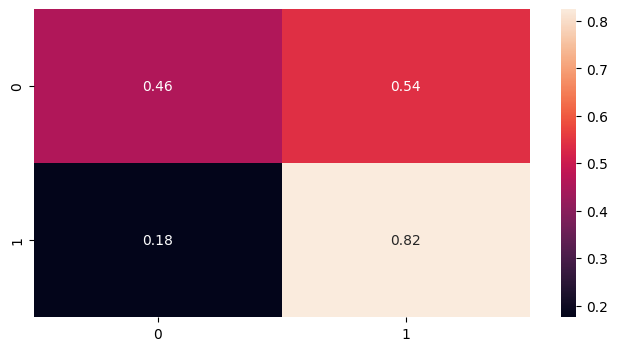

In [27]:
# Test values confusion matrix
conf_mx = confusion_matrix(test_players_labels, test_value_predictions_proba_v1[:, 1] > ideal_threshold)
conf_mx = conf_mx.astype('float') / conf_mx.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mx, annot=True, fmt='.2f')

Here I just want to understand how my model really performed, in terms of value earned. How does it compare with just buying all players? How does it compare to the maximum performance?

In [33]:
def perf(minval, maxval):
    return round(minval/maxval, 2)

test_value_predictions_proba_v1 = value_predictor_v1.predict_proba(test_players_prepared)

test_players_v1 = x_test[['Name', 'Age', 'Position', 'Club', 'PA', 'value_diff', 'value_2020']]
test_players_v1['pred'] = test_value_predictions_proba_v1[:, 1] > ideal_threshold

test_total_value_without_model = test_players_v1['value_diff'].sum()
test_total_value_with_model = test_players_v1.query('pred == 1')['value_diff'].sum()
test_max_value_without_model = test_players_v1.query('value_diff > 0')['value_diff'].sum()

test_performance = test_total_value_with_model
max_test_performance = test_max_value_without_model

print("Perf:", perf(test_performance, max_test_performance))
print("Min Perf:", perf(test_total_value_without_model, max_test_performance))

Perf: 0.58
Min Perf: 0.24


## Results

Finally, I just want to see some of the most meaningful results.

### Successful

- 10 best value increase true predictions.
    - Most players predicted have less than or equal to 20 years old
    

In [30]:
test_players_v1.query('pred == 1').sort_values('value_diff', ascending=False).head(10)

,Name,Age,Position,Club,PA,value_diff,pred
3026,Alphonso Davies,18,"D/WB (L), M/AM (RL)",FC Bayern,168,49500000.0,True
419,Amine Gouiri,19,"AM (L), ST (C)",OGC Nice,154,33750000.0,True
1888,Alessandro Bastoni,20,D (C),Inter,169,33300000.0,True
335,Wesley Fofana,18,"D (C), DM",Leicester,165,32400000.0,True
1157,Ryan Gravenberch,17,"DM, M (C), AM (LC)",Ajax,175,27000000.0,True
613,Declan Rice,20,"D (C), DM, M (C)",West Ham,180,27000000.0,True
1244,Sven Botman,19,D (LC),LOSC,119,26730000.0,True
1009,Pedro Goncalves,20,M/AM (C),FamalicÃ£o,125,26280000.0,True
633,Curtis Jones,18,"M (C), AM (RLC)",Liverpool,150,23850000.0,True
382,Robin Le Normand,22,D (C),Real Sociedad,143,22500000.0,True


- 10 best value increase true predictions for players with low potential (so they are players which would be "under the radar" of big clubs)
    - Most players predicted come from lower leagues (which can indicate that this is an important factor)

In [31]:
test_players_v1.query('pred == 1 and PA < 130').sort_values('value_diff', ascending=False).head(10)

,Name,Age,Position,Club,PA,value_diff,pred
1244,Sven Botman,19,D (LC),LOSC,119,26730000.0,True
1009,Pedro Goncalves,20,M/AM (C),FamalicÃ£o,125,26280000.0,True
1387,Lucas BoyÃ©,23,"AM (RLC), ST (C)",Elche,125,12420000.0,True
1644,Manu SÃ¡nchez,23,D/WB/M/AM (R),R. Majadahonda,120,8550000.0,True
1967,Simone Bastoni,22,"D/WB (L), M (LC)",Spezia,123,6570000.0,True
2879,Tarik Tissoudali,26,"M/AM (RL), ST (C)",Beerschot VA,107,6210000.0,True
812,Ismail Jakobs,19,D/WB/M/AM (L),1. FC KÃ¶ln,125,6210000.0,True
2725,Konstantin Tyukavin,17,ST (C),Dinamo Moscow,103,6187000.0,True
1988,Mattia Viti,17,D (C),Empoli,100,6075000.0,True
1974,Andrea Cambiaso,19,"WB (R), M (RC)",Genoa,123,4342000.0,True


- 10 players with a big increase in valuation, comparing with 2020
    - Again most players have less than or equal to 20 years old

In [34]:
test_players_v1.query('pred == 1 and value_2020 <= 1000000').sort_values('value_diff', ascending=False).head(10)

,Name,Age,Position,Club,PA,value_diff,value_2020,pred
1244,Sven Botman,19,D (LC),LOSC,119,26730000.0,270000,True
1009,Pedro Goncalves,20,M/AM (C),FamalicÃ£o,125,26280000.0,720000,True
1021,FÃ¡bio Vieira,19,"M (C), AM (LC)",FCP,155,21870000.0,630000,True
722,Noni Madueke,17,"M (RL), AM (RLC)",PSV,148,15660000.0,540000,True
525,Georginio Rutter,17,"AM (RL), ST (C)",TSG Hoffenheim,156,13950000.0,450000,True
1611,Nico Williams,16,"D (C), M/AM (RL)",A. Bilbao,148,9900000.0,900000,True
864,Ansgar Knauff,17,D/M/AM (R),Borussia Dortmund,138,8865000.0,135000,True
1644,Manu SÃ¡nchez,23,D/WB/M/AM (R),R. Majadahonda,120,8550000.0,450000,True
708,Stephy Mavididi,21,ST (C),Montpellier,135,8100000.0,900000,True
2278,Mykhaylo Mudryk,18,AM (RLC),Shakhtar,138,7920000.0,180000,True


- 10 players who devalued the most and the model predicted successfully
    - Most players are older than 23 yo
    - All players come from big leagues (again reinforcing the importance of the league a player is)

In [38]:
test_players_v1.query('pred == 0').sort_values('value_diff', ascending=True).head(10)

,Name,Age,Position,Club,PA,value_diff,value_2020,pred
1347,Mauro Icardi,26,ST (C),Paris SG,174,-47700000.0,67500000,False
1,Philippe Coutinho,27,M/AM (LC),Barcelona,172,-45000000.0,63000000,False
1998,Nicolas PÃ©pÃ©,24,"AM (R), ST (C)",Arsenal,159,-45000000.0,67500000,False
312,Anthony Martial,23,"AM (L), ST (C)",Man Utd,170,-39600000.0,54000000,False
304,Kylian MbappÃ©,20,"AM (RL), ST (C)",Paris SG,196,-36000000.0,180000000,False
9,Felipe Anderson,26,"M (RL), AM (RLC)",FCP,159,-28800000.0,40500000,False
1876,Federico Bernardeschi,25,"M (R), AM (RLC)",Juventus,167,-27000000.0,36000000,False
1134,Frenkie de Jong,22,"D (C), DM, M (C)",Barcelona,183,-27000000.0,81000000,False
923,JoÃ£o FÃ©lix,19,"AM (RLC), ST (C)",A. Madrid,175,-27000000.0,90000000,False
3168,Ãlvaro Morata,26,ST (C),Juventus,170,-22500000.0,45000000,False


### Unsuccessful

- 10 players who were not predicted as having a big increase in valuation and had
    - Most players are above 22 yo
    - The most valuable player is the youngest at 16
        - Maybe if the value in 2020 is small enough and the age is small (16-19), the model can be more permissive as most young players are expected to value a lot
    - 4 players are from the German league (is it undervalued?)

In [40]:
test_players_v1.query('pred == 0').sort_values('value_diff', ascending=False).head(10)

,Name,Age,Position,Club,PA,value_diff,value_2020,pred
1566,Pedri,16,"M (C), AM (RLC)",Barcelona,160,67500000.0,4500000,False
2590,Patrik Schick,23,ST (C),Bayer 04,168,31500000.0,13500000,False
10,Raphinha,22,AM (RL),Leeds,157,27900000.0,12600000,False
3169,Guido RodrÃ­guez,25,"DM, M (C)",Real Betis,147,13500000.0,9000000,False
1351,Rodrigo De Paul,25,"M (C), AM (RLC), ST (C)",Udinese,155,13500000.0,22500000,False
758,Leon Goretzka,24,"DM, M/AM (C)",FC Bayern,173,13500000.0,45000000,False
402,Jonathan Clauss,26,D/WB/M/AM (R),RC Lens,122,12825000.0,675000,False
2538,Daichi Kamada,22,"M/AM (C), ST (C)",Eintracht Frankfurt,134,11700000.0,8100000,False
815,Robert Andrich,24,"DM, M (C)",Union Berlin,131,10800000.0,900000,False
3186,Kostas Tsimikas,23,D/WB (L),Liverpool,150,10350000.0,3150000,False


- 10 players who were not predicted as having a big decrease in valuation and had
    - Mostly players between 20-22 yo
    - Players in big clubs
        - 3 players from the spanish league (overvalued?)

In [41]:
test_players_v1.query('pred == 1').sort_values('value_diff', ascending=True).head(10)

,Name,Age,Position,Club,PA,value_diff,value_2020,pred
1512,Dani Ceballos,22,M/AM (C),Arsenal,163,-27900000.0,40500000,True
3155,Marcos Llorente,24,"DM, M/AM (C)",A. Madrid,158,-27000000.0,67500000,True
587,Trent Alexander-Arnold,20,"D/WB (R), DM, M (C)",Liverpool,178,-27000000.0,99000000,True
343,Houssem Aouar,20,M/AM (LC),OL,169,-22500000.0,45000000,True
362,Dan-Axel Zagadou,20,D (C),Borussia Dortmund,157,-17100000.0,25200000,True
21,Malcom,22,AM (RL),Zenit,163,-16200000.0,36000000,True
1502,Igor Zubeldia,22,"D (C), DM, M (C)",Real Sociedad,151,-13500000.0,27000000,True
2199,Ozan Kabak,19,D (C),Liverpool,150,-10800000.0,19800000,True
411,Colin Dagba,20,D (RL),Paris SG,145,-9900000.0,16200000,True
547,Malang Sarr,20,D (LC),FCP,156,-9000000.0,16200000,True


## Future work

There is still a lot to be done in terms of perfecting the results of the model

### What is missing

- A proper EDA. There was few explanation of the datasets I'm working and of the decisions took about which data was selected and used.

### Some questions

- How to better define performance metrics?
    - What should define success in the model?
        - In theory we want to increase the number of excellent investments in players, and find some "hidden" gems (e.g. not only the algorithm should predict already great players who obviously will increase in value, but also players who are not so obvious)

- How to analyse the errors, and act upon that analysis?
    - Right now the only analysis done points to:
        - A difficulty evaluating very young players
        - Overvaluation of big league players
        - How can we implement this analysis and improve the model for these players?
    - How to better do error analysis?

- How can we increase the quality and quantity of our base dataset?
    - From more that 100k data points who are FM 20, we are reduced to only 2985.
        - This is due to a lack of data in transfermarkt
        - If we can find a strong correlation with some feature with an increase in value (e.g. if a player in 2020 has higher attributes than in 2017, then it has a higher value), can we extrapolate an increase in value without using exact data from Transfermarkt?
        - So for instance we can use this to find a correlation in a sample of matching data between FM17, FM20 and Transfermarkt and then extrapolate.
    - Can I better match the players in FM and Transfermarkt?
        - Use the club which the players were? Can I use somehow a fuzzy match (as clubs have different denominations in different dataframes)?
        - Use not only the transfermarkt country of citizenship but also country of birth somehow can improve matches where a player appears with his country of birth in FM?
        - Use the same fuzzy matching I use with the missing players, but with all of them? 
        
- How can we properly add weights to more relevant increases/decreases in value?
    - It is way more important for the model to be able to correctly predict big changes in value than small ones.
    - Does it make sense dividing in 3 groups (big decrease, small change - positive or negative, big increase)
    - How to incorporate big variations in price? E.g. players who even though the change is small - e.g. from 200k to 2M -, it varies a lot (positively or negatively)

- How can we extract more relevant features?
    - E.g. players tend to devalue if there are only 1 year left in their contract.

- Is the current value of a player a proper evaluator of the "real value" of a player?
    - Maybe the instantaneous value of a player in a given time is not really what we're looking for as a success measure.
    - Looking in the eyes of an investor, why wouldn't I want to invest in a young player who devalued due to some unforeseen circumstances (a failed transfer, an injury, a coach who doesn't like him), even though my attributes actually increased and I am a better player?

- How to better improve documentation?
    - I feel most of the questions and answered while I made this work were lost due to lack of documentation (which was made post work instead of during it). I would love to know how to properly document those questions, how I found the answers to them, why I decided on certain values, etc...

### Additional work
- Create an api in which we can feed player attributes, and then tell the ML algorithm whether the player increased or not in value in the past 3 years
- Create a simple front-end for this
- Make the system work online (the model improves itself with the new information being given)